List of original code files incorporated into this notebook:
- bias_err_T2.py
- bias_corr.py
- cycles.py
- elev2.py
- elevations.py
- vert_T.py

List of files deemed outdated:
- bias_mean.py

List of plot files incorporated:
- landsea.pdf
- T2
    - daily_errors.pdf
    - annual_daily_model.pdf (i.e. annual, daily cycles based on Lomb-Scargle 'model' invocation)
    - bias_corr_bars.pdf
    - bias_corr_kde.pdf
    - bias_daily_max.pdf
    - bias_daily_min.pdf
    - bias_maps.pdf
    - bias_maps2.pdf
    - MAE_maps.pdf
    - seasonal_cycles.pdf
    - seasonal_errors.pdf
    - lapse_kde_d02.pdf
    - lapse_kde_d03orl.pdf
    - T2_elev_corr_d02.pdf
- T
    - T_p_d02_raw_log.pdf
    - daily_diff_p_d02.pdf

In [1]:
import sys
sys.path.append('../../code/python')
import numpy as np
import pandas as pd
import helpers as hh
import interpolation as ip
import mapping as mp
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.figure import SubplotParams
from astropy.stats import LombScargle
from scipy.stats import gaussian_kde
from functools import partial
%matplotlib inline
# rc('font', **{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('text', usetex=True)
plt.rcParams.update({'text.usetex': False, 'mathtext.fontset': 'stixsans'})

In [1]:
Map = hh.basemap()

def plot(B, cols=None, clims=None, cbars='row'):
    if cols is not None:
        B = B.loc[:, :, cols]
    if clims is None:
        cl = pd.concat((B.min(1).min(), B.max(1).max()), 1)
    for k, b in B.iteritems():
        for j, x in enumerate(B.minor_axis):
            ax = plt.subplot(B.shape[0], B.shape[2], k * B.shape[2] + j + 1)
            D = pd.concat((sta.loc[B.major_axis, ('lon', 'lat')], b[x]), axis=1).dropna()
            if k == 0:
                ax.set_title(x)
            Map.scatter(D['lon'].as_matrix(), D['lat'].as_matrix(), c=D.iloc[:,-1], marker='o', latlon=True)
            Map.drawcoastlines()
            Map.drawparallels(range(-32, -28, 1), labels=[j==0, 0, 0, 0])
            Map.drawmeridians(range(-72, -69, 1), labels=[0, 0, 0, k==B.shape[0]-1])
            if cbars=='all':
                plt.colorbar()
            else:
                if clims is None:
                    plt.clim(cl[0][k], cl[1][k])
                else:
                    try:
                        plt.clim(clims[k][0], clims[k][1])
                    except TypeError:
                        plt.clim(-clims[k], clims[k])
                if j == B.shape[2] - 1:
                    bb = ax.get_position()
                    plt.colorbar(
                        cax=fig.add_axes([bb.x1 + 0.02, bb.y0, 0.02, bb.y1 - bb.y0]))

NameError: name 'hh' is not defined

In [3]:
# helper to get the correct elevation data for each model 'name'
def dem(s):
    if s=='d03_orl': return s
    elif s[:3]=='d03': return 'd03_op'
    else: return s[:3]
    

D = pd.HDFStore('../../data/tables/station_data.h5')

# CEAZAMet station location info
sta = D['sta']

# CEAZAMet station 2m temperature in K
T = hh.stationize(D['ta_c'].xs('prom', 1, 'aggr').drop(10, 1, 'elev')) + 273.15

S = pd.HDFStore('../../data/tables/LinearLinear.h5')

# model 2m temperature linearly interpolated to station location
Tm = S['T2n']

# temperature bias (model minus stations)
B = Tm.add( -T )

# mean bias
Bm = B.mean(1)

# elevations of station locations on respective model DEMs
Z = S['z'][[dem(z) for z in B.items]]
Z.columns = B.items

# elevation difference (true station elevation minus DEM)
dz = (sta['elev'] - Z.T).T

OSError: ``../../data/tables`` does not exist

## Land-Sea mask

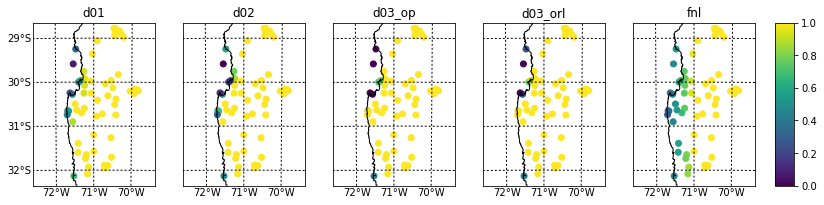

In [7]:
fig = plt.figure(figsize=(13, 3))
plt.set_cmap('viridis')
plot(pd.Panel({0:S['land_mask']}))

Linear interpolation of land (1) and sea (0) values to station locations on the various model grids.

## T2

### Mean bias

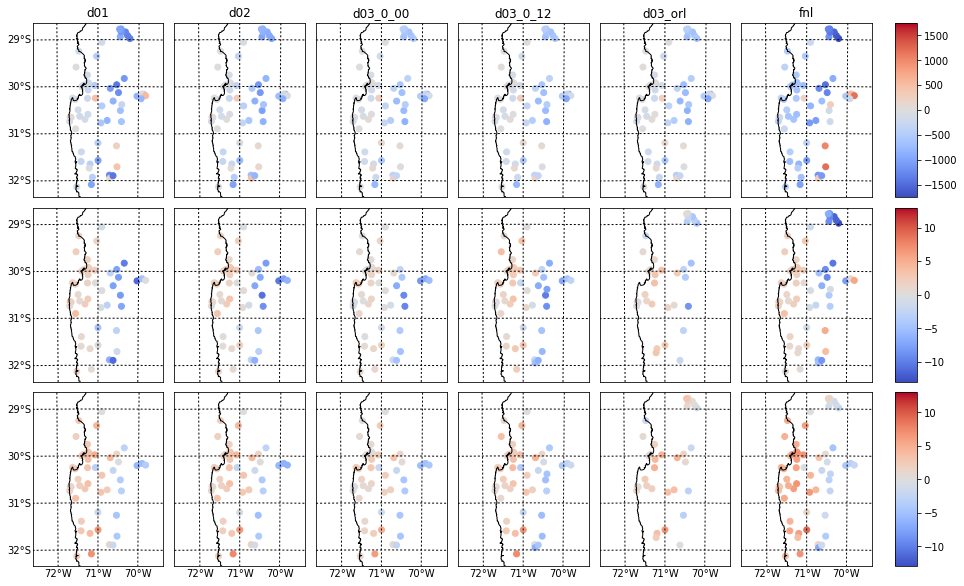

In [8]:
fig = plt.figure(
    figsize=(15, 10),
    subplotpars=SubplotParams(left=0.08, right=0.86, wspace=0.06, hspace=0.06))
plt.set_cmap('coolwarm')
x = ['d01', 'd02', 'd03_0_00', 'd03_0_12', 'd03_orl', 'fnl']
plot(pd.Panel({0:dz, 1:Bm, 2:Bm - 0.0065 * dz}), cols=x, clims=[1750,13,13])

**top**: elevation bias (true station elevation minus model DEM elevation interpolated to station location)  
**middle**: 2m temperature bias (model - station)  
**bottom**: temperature bias after correcting for a mean lapse rate of 6.5K / km

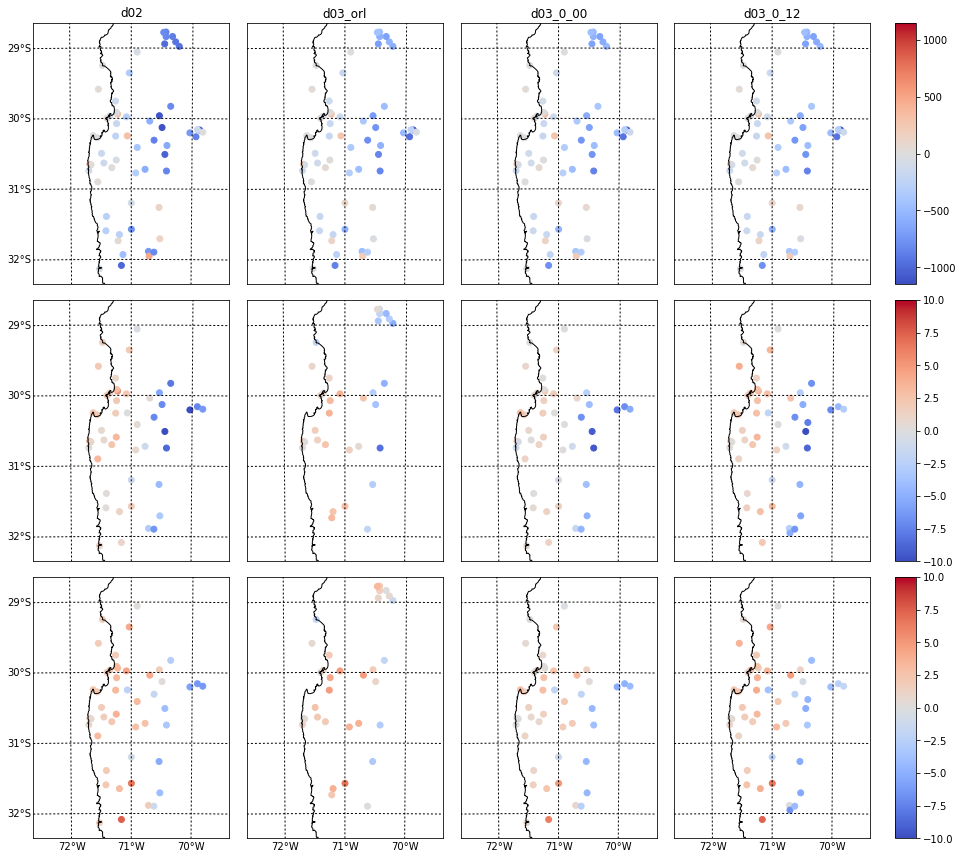

In [9]:
fig = plt.figure(
    figsize=(15,15),
    subplotpars=SubplotParams(left=0.08, right=0.86, wspace=0.06, hspace=0.06))
plt.set_cmap('coolwarm')
x = ['d02', 'd03_orl', 'd03_0_00', 'd03_0_12']
plot(pd.Panel({0:dz, 1:Bm, 2:Bm - 0.0065 * dz}), cols=x, clims=[1150, 10, 10])

same as above but for selected domains only (less variance for same color scales)

**top**: elevation bias (true station elevation minus model DEM elevation interpolated to station location)  
**middle**: 2m temperature bias (model - station)  
**bottom**: temperature bias after correcting for a mean lapse rate of 6.5K / km

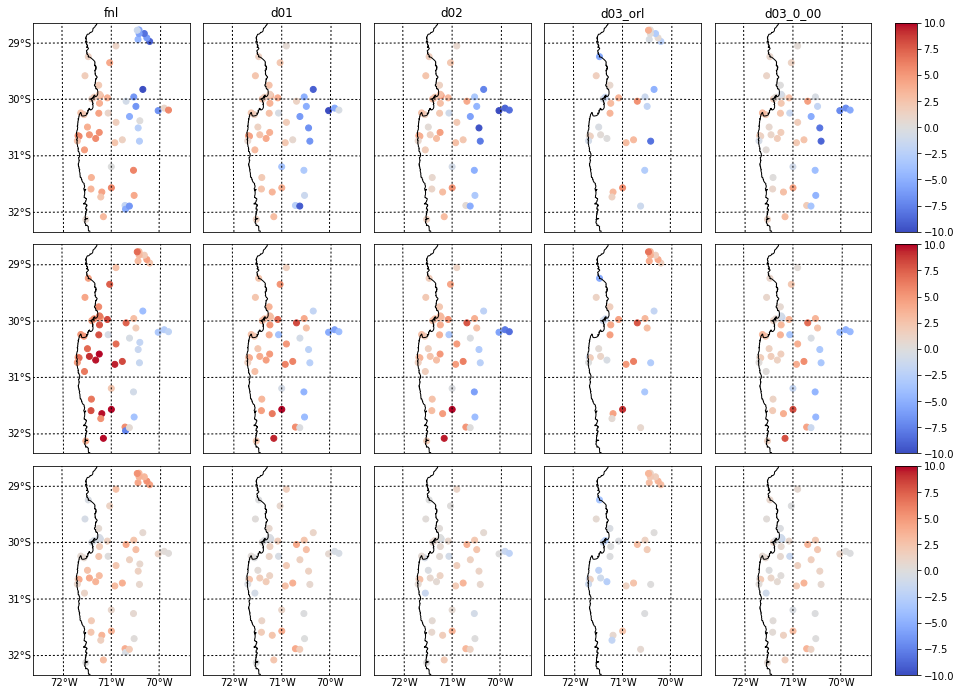

In [10]:
x = ['fnl', 'd01', 'd02', 'd03_orl', 'd03_0_00']

fig = plt.figure(
    figsize=(15, 12),
    subplotpars=SubplotParams(left=0.08, right=0.86, wspace=0.06, hspace=0.06))
plt.set_cmap('coolwarm')

day = lambda x: x.groupby(lambda y: y.date).min()
dt = day(T) # daily min of station data
P = pd.Panel({
    0: day(Tm).add(-dt).mean(1), # daily min of model data minus daily min of station data
    1: day( Tm.add( -0.0065 * dz, 1) ).add(-dt).mean(1), # model data corrected by standard lapse rate
    2: day( Tm.add(-Bm, 1) ).add(-dt).mean(1) # model data with mean bias removed
})

plot(P, cols=x, clims=[10, 10, 10])

**top**: mean bias of daily **minimum** temperatures (model minus station)  
**middle**: mean bias after correction for mean lapse rate of 6.5K / km  
**bottom**: mean bias of daily minimum after removing mean bias (over all records)

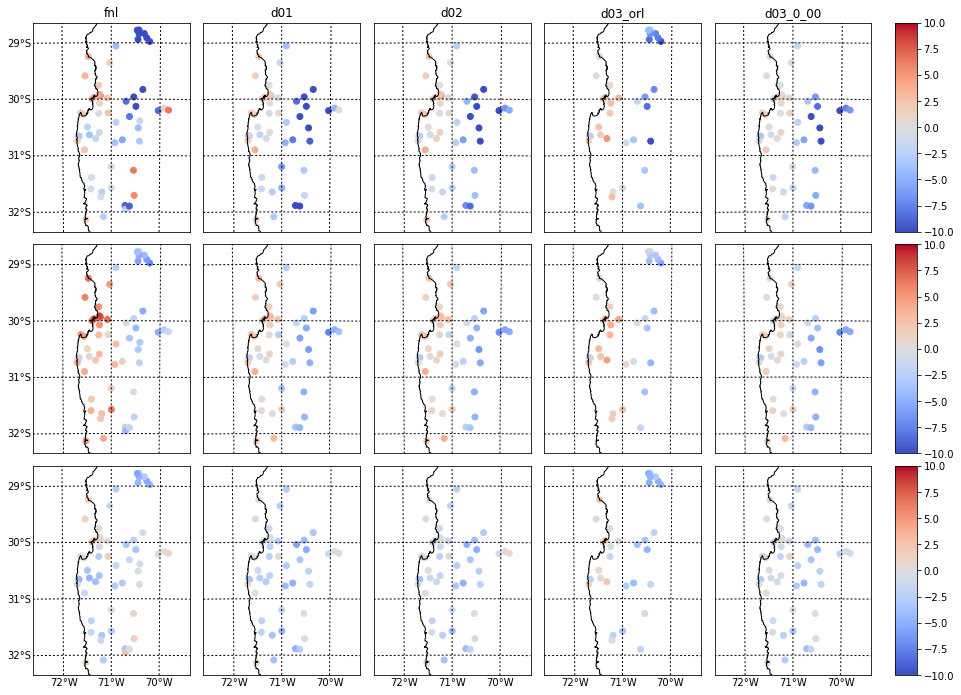

In [11]:
x = ['fnl', 'd01', 'd02', 'd03_orl', 'd03_0_00']

fig = plt.figure(
    figsize=(15, 12),
    subplotpars=SubplotParams(left=0.08, right=0.86, wspace=0.06, hspace=0.06))
plt.set_cmap('coolwarm')

day = lambda x: x.groupby(lambda y: y.date).max()
dt = day(T) # daily min of station data
P = pd.Panel(
    {
        0: day(Tm).add(-dt).mean(1), # daily min of model data minus daily min of station data
        1: day( Tm.add( -0.0065 * dz, 1) ).add(-dt).mean(1), # model data corrected by standard lapse rate
        2: day( Tm.add(-Bm, 1) ).add(-dt).mean(1) # model data with mean bias removed
    }
)

plot(P, cols=x, clims=[10, 10, 10])

**top**: mean bias of daily **maximum** temperatures (model minus station)  
**middle**: mean bias after correction for mean lapse rate of 6.5K / km  
**bottom**: mean bias of daily maximum after removing mean bias (over all records)

### Mean absolute error (MAE)

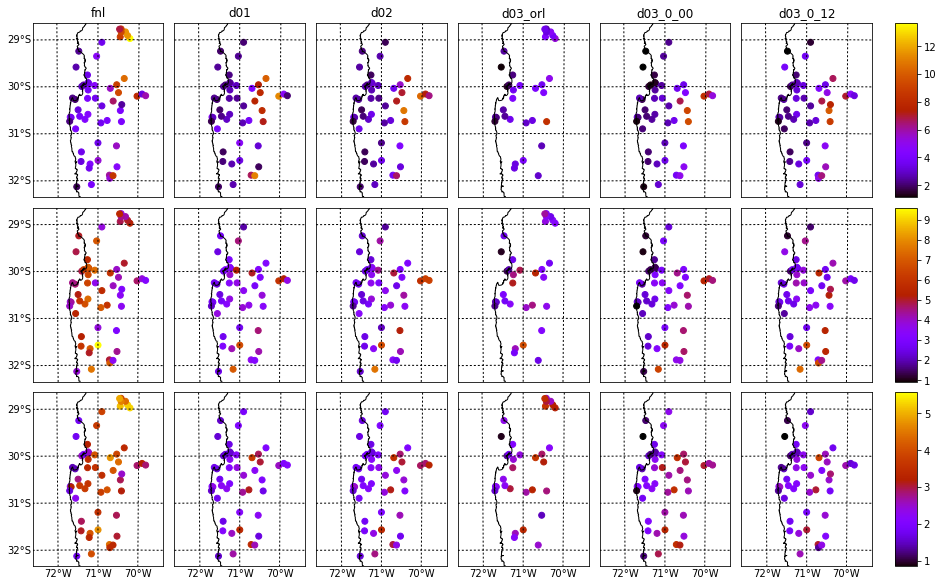

In [12]:
x = ['fnl', 'd01', 'd02', 'd03_orl', 'd03_0_00', 'd03_0_12']

fig = plt.figure(
    figsize=(15, 10),
    subplotpars=SubplotParams(left=0.08, right=0.86, wspace=0.06, hspace=0.06))
plt.set_cmap('gnuplot')

P = pd.Panel({
    0: abs(B).mean(1), # mean absolute error (MAE)
    1: abs( B.add( -0.0065 * dz, 1 ) ).mean(1), # MAE after lapse rate adjustment
    2: abs( B.add(-Bm, 1) ).mean(1) # MAE after removal of mean bias
})

plot(P, cols=x)

**top**: mean absolute error (MAE) of 2m temperature (model/station)  
**middle**: MAE after correction for mean lapse rate of 6.5K / km  
**bottom**: MAE after removal of mean bias

### Skewness & kurtosis

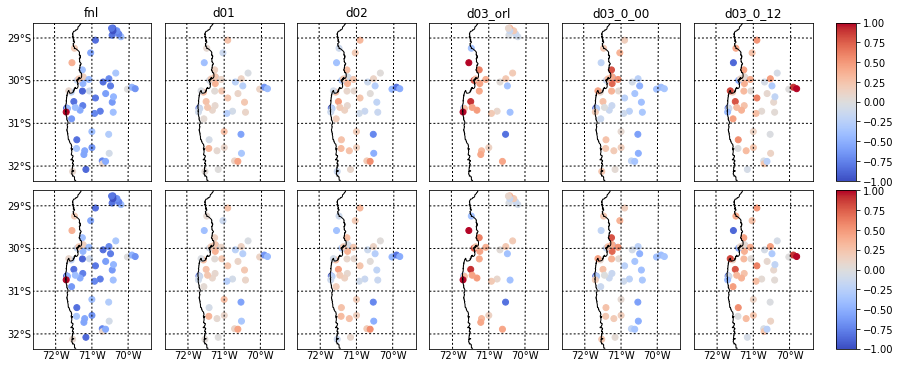

In [48]:
x = ['fnl', 'd01', 'd02', 'd03_orl', 'd03_0_00', 'd03_0_12']

fig = plt.figure(
    figsize=(14,6),
    subplotpars=SubplotParams(left=0.08, right=0.86, wspace=0.06, hspace=0.06))
plt.set_cmap('coolwarm')

P = pd.Panel({
    0: B.skew(1),
    1: B.add( -0.0065 * dz, 1 ).skew(1),
})

plot(P, cols=x, clims=[1, 1])

**Note:** There are outliers in the data (viz. **CT, MARIP**) which show up only in comparison with those model runs with which they overlap in time (viz. d03_orl, fnl).

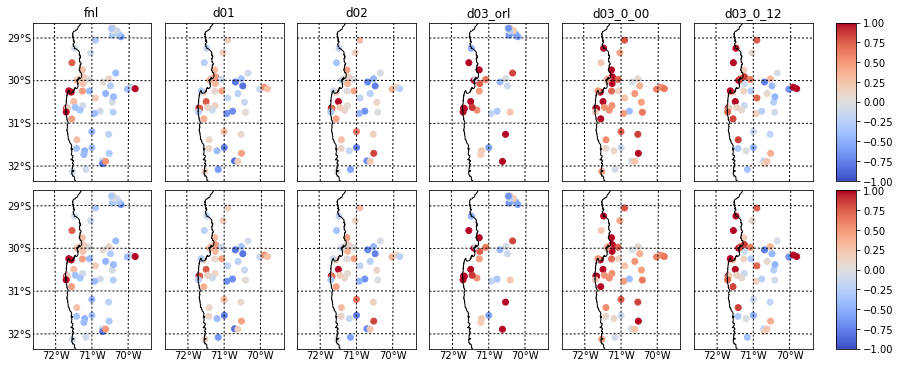

In [55]:
x = ['fnl', 'd01', 'd02', 'd03_orl', 'd03_0_00', 'd03_0_12']

fig = plt.figure(
    figsize=(14, 6),
    subplotpars=SubplotParams(left=0.08, right=0.86, wspace=0.06, hspace=0.06))
plt.set_cmap('coolwarm')

P = pd.Panel({
    0: B.kurt(1),
    1: B.add( -0.0065 * dz, 1 ).kurt(1)
})

plot(P, cols=x, clims=[1, 1])

**Note:** Kurtosis computed by pandas is obviously standardized (-3).

## Cycles

In [ ]:
# This gives a good current approximation to the solar year length in seconds
def pow(d, T=np.timedelta64(1, 'Y').astype('timedelta64[s]'), return_period=False):
    f = lambda k: k.astype(float)
    try:
        c = d.dropna()
        t = np.array(c.index, dtype='datetime64[s]')
        n = np.arange(t[0], t[0]+T, dtype='datetime64[h]').astype('datetime64[s]')
        if (t[-1] - t[0]) < T / 4: return np.nan
        x = c.as_matrix()
        y = LombScargle(f(t), x).model(f(n), f(T)**-1)
        return pd.Timestamp(n[y.argmax()]).month if return_period else max(y) - min(y)
    except:
        return np.nan

In [ ]:
x = ['obs', 'fnl', 'd01', 'd02', 'd03_orl', 'd03_0_00']

fig = plt.figure(
    figsize=(15, 7),
    subplotpars=SubplotParams(left=.1, right=.96, bottom=.06, top=.92, wspace=.1, hspace=.1))
plt.set_cmap('gnuplot')

d = dict(Tm)
d['obs'] = T
d = pd.Panel(d)
std = d.groupby(d.major_axis.month).std()
std.major_axis = std.major_axis.astype('datetime64[M]')

P = pd.Panel({
    0: d.apply(pow, 1),
    1: std.mean(1),
    2: std.apply(pow, 1)
})

plot(P, cols=x, cbars='all')

**top**: amplitude of annual cycle in 2m temperatures for observations and models (peak-to-peak, $2 \hat{U}$)  
**middle**: mean monthly standard deviation of 2m temperatures  
**bottom**: amplitude of annual cycle (as above) of monthly standard deviation

**Note**: The annual cycle is computed from a Lomb-Scargle periodogram, as this is known to work reliably even for lengths of records of only a fraction of the period under investigation. The amplitude is computed from the model reconstruction of the astropy.stats.LombScargle algorithm, since the normalization of the Lomb-Scargle periodogram is not directly related to that of a Fourier transform.

In [ ]:
x = ['fnl', 'd01', 'd02', 'd03_orl', 'd03_0_00']

fig = plt.figure(
    figsize=(15, 6),
    subplotpars=SubplotParams(left=.1, right=.96, bottom=.06, top=.92, wspace=.1, hspace=.1))
plt.set_cmap('gnuplot')

std = B.groupby(B.major_axis.month).std()
std.major_axis = std.major_axis.astype('datetime64[M]')

P = pd.Panel({
    0: B.apply(pow, 1),
    1: std.apply(pow, 1)
})

plot(P, cols=x, cbars='all')

**top**: amplitude of annual cycle (see above) of 2m temperature **bias** (model minus station)  
**bottom**: amplitude of annual cycle of monthly standard deviation of temperature bias

In [ ]:
x = ['obs', 'fnl', 'd01', 'd02', 'd03_orl', 'd03_0_00']

fig = plt.figure(
    figsize=(15, 3),
    subplotpars=SubplotParams(left=.1, right=.96, bottom=.06, top=.92, wspace=.12, hspace=.1))
plt.set_cmap('hsv')

plot(pd.Panel({0: d.apply(pow, 1, return_period=True)}), cols=x, clims=[(1,12)])

**Phase** of annual cycle of 2m temperatures (as month 1-12), computed from Lomb-Scargle reconstrution

In [ ]:
x = ['obs', 'fnl', 'd01', 'd02', 'd03_orl', 'd03_0_00']

fig = plt.figure(
    figsize=(15, 6),
    subplotpars=SubplotParams(left=.1, right=.96, bottom=.06, top=.92, wspace=.1, hspace=.1))
plt.set_cmap('gnuplot')

P = pd.Panel({
    0: d.apply(pow, 1),
    1: d.apply(pow, 1, T=np.timedelta64(1, 'D').astype('timedelta64[s]')),
})

plot(P, cols=x)

**top**: amplitude of annual cycle (see above) of 2m temperatures  
**bottom**: amplitude of daily cycle, computed in the same way

## Kernel density estimates (KDE) of errors

In [ ]:
# compute values of 2x2 contingency table (a, b, c, d)
def abcd(df):
    m = df.notnull().astype(int)
    n = df.shape[0]
    a = np.where(m.sum(axis=1)==2)[0].shape[0]
    b,c = [np.where(m.diff(axis=1)[1]==i)[0].shape[0] for i in [1,-1]]
    d = n-a-b-c
    return a,b,c,d,n

x = np.linspace(-20,20,100)

P = [Tm, Tm.add(-0.0065 * dz, 1), Tm.add(-Bm, 1), Tm.add(-B.apply(lambda x:x.rolling('7D').mean(), 1))]

cols = np.array([['fnl','d01','d02'],['d03_orl','d03_0_00','d03_0_12'],['d03_0_00','d03_1_00','d03_4_00']])
fig,axs = plt.subplots(*cols.shape, figsize=(15, 10))
mae = np.zeros(np.r_[cols.shape,4])
cold = np.zeros_like(mae)
heat = np.zeros_like(mae)
for i, row in enumerate(cols):
    for j, s in enumerate(row):
        plt.sca(axs[i,j])
        axs[i,j].set_title(cols[i,j])

        for h,f in enumerate(P):
            y = f[s]-T
            fg = f[s].groupby(f[s].index.date)
            Tg = T.groupby(T.index.date)
            mae[i,j,h] = abs(y).mean().mean()
            k = gaussian_kde(y.stack().dropna())

            p = pd.Panel({0: Tg.min(), 1:fg.min()}).to_frame()
            a,b,c,d,n = abcd(p[p<hh.K])
            cold[i,j,h] = a/(a+b+c)

            p = pd.Panel({0: Tg.max(), 1:fg.max()}).to_frame()
            a,b,c,d,n = abcd(p[p>hh.K+30])
            heat[i,j,h] = a/(a+b+c)
            plt.plot(x,k(x))

        plt.grid()
        
for ax in axs.flatten():
    ax.set_ylim(0,0.2)
    ax.set_yticklabels([])

for ax in axs[:2,:].flatten():
    ax.set_xticklabels([])

In [4]:
dz

,d01,d02,d02_0_00,d02_0_12,d03_0_00,d03_0_12,d03_1_00,d03_4_00,d03_4_12,d03_orl,fnl
CGR,194.858286,340.725119,340.725119,340.725119,363.139473,363.139473,363.139473,363.139473,363.139473,364.666196,-236.788701
BTG,-96.822356,-29.083954,-29.083954,-29.083954,-8.224939,-8.224939,-8.224939,-8.224939,-8.224939,-15.458220,-470.135986
TLH,-176.942230,-57.814509,-57.814509,-57.814509,16.366256,16.366256,16.366256,16.366256,16.366256,21.032109,-683.662121
LCAR,-179.389528,-241.429227,-241.429227,-241.429227,-187.541231,-187.541231,-187.541231,-187.541231,-187.541231,-193.500382,-540.481957
MARIP,2.297633,38.870278,38.870278,38.870278,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,-391.933234
COMB,-439.825575,-84.488656,-84.488656,-84.488656,112.710190,112.710190,112.710190,112.710190,112.710190,118.254425,-364.233329
CACH,-159.936713,-78.147718,-78.147718,-78.147718,12.774969,12.774969,12.774969,12.774969,12.774969,2.634528,-231.830494
LSC,-189.063188,-56.354964,-56.354964,-56.354964,17.103848,17.103848,17.103848,17.103848,17.103848,12.356453,-639.850212
9,-467.800812,-303.106600,-303.106600,-303.106600,-112.729518,-112.729518,-112.729518,-112.729518,-112.729518,-148.628281,-699.918499
8,-1199.192615,-1117.581705,-1117.581705,-1117.581705,-673.325837,-673.325837,-673.325837,-673.325837,-673.325837,-737.373942,-1279.891639


In [ ]:
k = gaussian_kde(B['d03_0_00']['MARPCH'].dropna())

In [ ]:
x = np.linspace(-20,20,100)
plt.plot(x,k(x))

Kernel-density estimates of error distributions for various domains/models.

**blue**: no correction  
**yellow**: mean lapse rate of 6.5$^{\circ}$K km$^{-1}$  
**green**: mean bias removed  
**red**: 7-day moving average of bias removed

#### Notes
1. The heavy tail on the *cold* bias side (model too cold w.r.t data) is ameliorated when correcting for a mean lapse rate of 6.5 $^{\circ}$K km$^{-1}$.
1. However, the error around the mode of the distribution is worsened. **Does this mean some stations are located in permanently stable conditions?**
1. The changes due to lapse rate correction obviously become smaller for higher grid resolution.
1. Removal of mean bias (overall or moving) appears to shift the error distribution towards normal. However, the error (see MAE above) on a per-station basis increases. 
1. The difference between static and moving mean corrections diminishes for finer grids. **Does this suggest improved dynamics?**

In [ ]:
fig,axs = plt.subplots(*cols.shape, figsize=(15, 10))
cy = axs[0,0]._get_lines.prop_cycler
col = [next(cy)['color'] for i in range(4)]
x = np.arange(4)
for i in range(cols.shape[0]):
    for j in range(cols.shape[1]):
        axs[i,j].set_title(cols[i,j])
        plt.sca(axs[i,j])
        p = np.r_[mae[i:i+1,j],cold[i:i+1,j],heat[i:i+1,j]]
        plt.bar(x,p[0,:],color=col)
        axs[i,j].set_ylim((0,5.1))
        ax = axs[i,j].twinx()
        ax.bar(x+5,p[1,:],color=col)
        ax.bar(x+10,p[2,:],color=col)
        ax.set_ylim((0,0.81))
        axs[i,j].set_xticks([1.5,6.5,11.5])
        if i==2: axs[i,j].set_xticklabels(['MAE','TS < 0C', 'TS > 30C'])
        else: axs[i,j].set_xticklabels([])
        if j>0: axs[i,j].set_yticklabels([])
        if j<2: ax.set_yticklabels([])
        if i==1:
            if j==0: axs[1,0].set_ylabel('MAE')
            if j==2: ax.set_ylabel('threat score (TS)')

MAE and threat score <cite data-cite="2031184/BVKVAVZP"></cite> (page 263) of two scenarios:
1. Daily minimum below 0$^{\circ}$C ('< 0C')
1. Daily maximum above 30$^{\circ}$C ('> 30C')

**blue**: without correction  
**yellow**: with lapse rate 6.5K/km correction  
**green**: with mean bias removed  
**red**: with one-week running mean bias removed  

**Note**: Threat score of 1 is perfect, 0 is worst. Gives proportion of correct 'yes' forcasts of events after removing 'no' forcasts from consideration. 

In [ ]:
D.close()
S.close()

In [ ]:
g3 = Dataset('../../data/WRF/3d/geo_em.d03.nc')
Map = mp.basemap(g3)
lm = g3.variables['LANDMASK'][0,:,:]
g3.close()

n0 = Dataset('../../data/WRF/3d/d03_day0.nc')
x0 = ip.nc_interp(n0, 'T2', sta, method='linear', map=Map)
j = hh.tsplit(x0)
n0.close()

x0_1 = x0.iloc[:j,:]
x0_2 = x0.iloc[j:,:]

n4 = Dataset('../../data/WRF/3d/T2_4.nc')
x4 = ip.nc_interp(n4, 'T2', sta, method='linear', map=Map)
x4_1 = x4.iloc[:j,:]
x4_2 = x4.iloc[j:,:]
x4.close()

fig = plt.figure(figsize=(12,8))
for i,x in enumerate([Tm['d03_orl'],x0_1,x0_2,x4_1,x4_2]):
    y = (x-T)**2
    y = y.groupby(y.index.hour).mean().mean(1)
    plt.plot(y,label=['orl','op+0/00','op+0/12','op+4/00','op+4/12'][i])
plt.legend()
plt.grid()
xt = plt.gca().set_xticks(range(0,24,2))

Mean error stratified by hour of the day for selected experiments.
#### Legend
**orl**: Orlando's domain
**op**: forcast domain 3
**+a/b**: a - forecast lead time in days, b - initialization hour of GFS forecast

In [ ]:
from scipy.optimize import brute
from pyproj import Geod


L = -B.divide(dz, 1) * 1000


def landsea(r, lm, lonlat, d=5000):
    inv = partial(Geod(ellps='WGS84').inv,r['lon'],r['lat'])
    def dist(x,y):
        return inv(x,y)[2]
    dv = np.vectorize(dist)
    return np.any(1-lm[np.where(dv(*lonlat)<d)])

def partition(sea, dz):
    """
    dz = station - grid
    returns [above, a-inland, a-coast, below, b-inland, b-coast]
    """
    a = set(dz[dz>0].index) # -> station "a"bove grid level
    b = set(dz[dz<0].index) # -> station "b"elow grid level
    b_s = b.intersection(sea)
    a_s = a.intersection(sea)
    return [list(s) for s in (a, a-a_s, a_s, b, b-b_s, b_s)]

def kplot(y,label,bw=0.1):
    x = np.linspace(-20,20,100)
    k = gaussian_kde(y.stack().dropna(),bw)
    m = brute(lambda z:-k(z),((-20,10),))
    plt.plot(x,k(x),label='{}: {:.2f}'.format(label,m[0]))
    return m[0]

def mode(y,bw=0.1):
    k = gaussian_kde(y.stack().dropna(),bw)
    m = brute(lambda z:-k(z),((-20,10),))
    return m[0]

def topplot(ax, ab):
    plt.sca(ax)
    plt.axvline(-9.8, color='grey', ls='--')
    plt.axvline(-6.5, color='grey', ls=':')
    plt.grid()   
    plt.title('station ${}$ grid'.format(ab))
    plt.gca().set_xlabel('$\Delta$T')

def botplot(ax, a=None, b=None, lab=None):
    plt.sca(ax)
    if a is not None:
        plt.plot(a.groupby(a.index.hour).apply(mode), label='all')
        plt.plot(b.groupby(b.index.hour).apply(mode), label=lab)
        plt.legend()
    plt.gca().set_xticks([0,6,12,18])
    plt.axhline(-9.8, color='grey',ls='--')
    plt.axhline(-6.5, color='grey',ls=':')
    plt.grid()
    plt.gca().set_xlabel('hour')
    plt.gca().set_ylabel('$\Delta$T')


g3 = Dataset('../../data/WRF/3d/geo_em.d03.nc')
landmask = g3.variables['LANDMASK'][0,:,:]
lonlat = hh.lonlat(g3)
sea = sta[sta.apply(landsea, 1, lm=landmask, lonlat=lonlat)].index
g3.close()

In [ ]:
a, a_l, a_s, b, b_l, b_s = partition(sea, dz['d02'])
lr = L['d02']

fig, axs = plt.subplots(2, 2, figsize=(15,10)) 

topplot(axs[0, 0], '<')
kplot(lr[b],'all')
kplot(lr[b_l],'inland all')
kplot(lr[b_l][lr.index.hour==0],'inland 0h')
kplot(lr[b_l][lr.index.hour==12],'inland 12h')
plt.legend()

topplot(axs[0, 1], '>')
kplot(lr[a_l],'inland all', .001)
kplot(lr[a_l][lr.index.hour==0],'inland 0h', .001)
kplot(lr[a_l][lr.index.hour==12],'inland 12h', .001)
kplot(lr[a_s],'coast all')
kplot(lr[a_s][lr.index.hour==0],'coast 0h')
kplot(lr[a_s][lr.index.hour==12],'coast 12h')
plt.legend()

botplot(axs[1, 1])
plt.plot(lr[a].groupby(lr.index.hour).apply(lambda z:mode(z,.005)), label='all')
plt.plot(lr[a_l].groupby(lr.index.hour).apply(lambda z:mode(z,.001)), label='inland')
plt.plot(lr[a_s].groupby(lr.index.hour).apply(mode), label='coast')
plt.legend()

botplot(axs[1, 0], lr[b], lr[b_l], 'inland')

'Hypothetical' lapse rates arising from model errors: Model bias is converted to a lapse rate by dividing by elevation difference (between model grid and true station elevation) and multiplying by 1000. The mode (given in legend and plotted in bottom row) is found by optimizing the KDEs (shown in top row).

**Top**: KDE estimates of distribution of 2m temperature errors split according to 1) whether grid location is above or below true station location, 2) distance from shore, and 3) time of day. 'Inland' is everything > 5km from shore is given by the finest model domain ('d03_op').

**Bottom**: Mode of distributions computed by numerical optimization of KDE, stratified by hour of day.

Vertical / horizontal grey lines give dry (9.8 $^{\circ}$K km$^{-1}$, hatched) and standard (6.5 $^{\circ}$K km$^{-1}$, points) lapse rates.

In [ ]:
a, a_l, a_s, b, b_l, b_s = partition(sea, dz['d03_orl'])

lr = L['d03_orl']

fig, axs = plt.subplots(2, 2, figsize=(15,10)) 

topplot(axs[0, 0], '<')
kplot(lr[b],'all')
kplot(lr[b_l],'inland all')
kplot(lr[b_l][lr.index.hour==0],'inland 0h')
kplot(lr[b_l][lr.index.hour==12],'inland 12h')
plt.legend()

topplot(axs[0, 1], '>')
kplot(lr[a],'all')
kplot(lr[a_s],'coast all')
kplot(lr[a_s][lr.index.hour==0],'coast 0h')
kplot(lr[a_s][lr.index.hour==12],'coast 12h')
plt.legend()

botplot(axs[1, 0], lr[b], lr[b_l], 'inland')
botplot(axs[1, 1], lr[a], lr[a_s], 'coast')

In [ ]:
a, a_l, a_s, b, b_l, b_s = partition(sea, dz['d03_1_00'])

lr = L['d03_1_00']

fig, axs = plt.subplots(2, 2, figsize=(15,10)) 

topplot(axs[0, 0], '<')
kplot(lr[b],'all')
kplot(lr[b_l],'inland all')
kplot(lr[b_l][lr.index.hour==0],'inland 0h')
kplot(lr[b_l][lr.index.hour==12],'inland 12h')
plt.legend()

topplot(axs[0, 1], '>')
kplot(lr[a],'all')
kplot(lr[a_s],'coast all')
kplot(lr[a_s][lr.index.hour==0],'coast 0h')
kplot(lr[a_s][lr.index.hour==12],'coast 12h')
plt.legend()

botplot(axs[1, 0], lr[b], lr[b_l], 'inland')
botplot(axs[1, 1], lr[a], lr[a_s], 'coast')

In [ ]:
from scipy.stats import binned_statistic

def binned_plot(ax, x, values, color=None, label=None):
    me,b,n = binned_statistic(x,values,'mean',50)
    std = binned_statistic(x,values,np.nanstd,50)[0]
    xc = (b[:-1]+b[1:])/2
    ax.fill_betweenx(xc, me-2*std, me+2*std, color=color, alpha=.4)
    ax.plot(me, xc, color=color, label=label)

def plot(t, tm, T2, zm, Z, sta):
    a = pd.concat((t, sta['elev']), axis=1, keys=['T','z']).sort_values('z')
    b = pd.concat((tm, Z), axis=1, keys=['T','z']).sort_values('z')
    c = pd.concat((tm - 0.0065 * (sta['elev']-Z), sta['elev']), axis=1, keys=['T','z']).sort_values('z')

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig, ax = plt.subplots(1, figsize=(12,8))
    binned_plot(ax, zm, T2, color=colors[0], label='model mean / elev')
    ax.scatter(b['T'],b['z'], marker='+', color=colors[1], label='model station loc no adj')
    ax.scatter(c['T'],c['z'], marker='+', color=colors[2], label='model station loc adj for 6.5 K/km')
    ax.scatter(a['T'],a['z'], marker='+', color=colors[3], label='observations')
    ax.set_xlabel('T [K]')
    ax.set_ylabel('elev [m]')
    ax.legend(loc=3)

    
# model, complete field
nc = Dataset('../../data/WRF/2d/d02_2014-09-10.nc')
z = nc.variables['HGT'][:].flatten()

# use only one year of data so as to not bias towards a particular season
j = np.where(hh.get_time(nc)==np.datetime64('2014-12-31T00'))[0][0]
T2 = nc.variables['T2'][j:,:,:].mean(0).flatten()
nc.close()

# use only one year of data, s.a.
tm = Tm['d02']['2014-12-31':].mean()

# average over the same day in different years to avoid bias towards those that occur more often
t = T.groupby(T.index.dayofyear).mean().mean()

plot(t, tm, T2, z, Z['d02'], sta)

Average 2m temperatures in observations and model (d02). Blue line and shade represents average and standard deviation of T2 binned according to elevation intervals. Orange crosses plot T2 at grid elevations, green crosses at corresponding station elevation after adjusting for 6.5 $^{\circ}$K km$^{-1}$ mean lapse rate.

**Question**: seasonality?

In [ ]:
# model, complete field
nc = Dataset('../../data/WRF/3d/d03_day0.nc')
z = nc.variables['HGT'][:].flatten()

j = hh.tsplit(nc)
T2_00 = nc.variables['T2'][:j,:,:].mean(0).flatten()
#T2_12 = nc.variables['T2'][j:,:,:].mean(0).flatten()
nc.close()

# use only one year of data, s.a.
tm = Tm['d03_0_00'].mean()

# average over the same day in different years to avoid bias towards those that occur more often
t = T.groupby(T.index.dayofyear).mean().mean()

plot(t, tm, T2_00, z, Z['d03_0_00'], sta)

In [ ]:
from scipy.interpolate import interp1d
from IGRAraw import extract
import xarray as xr

with pd.HDFStore('../../data/IGRA/IGRAraw.h5') as S:
    sta = S['sta']

    
with xr.open_dataset('../../data/IGRA/IGRAmly.nc') as M:
    mly = M['temp']
    mly.load()

with Dataset('../../data/WRF/2d/d02_2014-09-10_transf.nc') as nc:
    Map = mp.basemap(nc)
    t = hh.get_time(nc)
    T = nc.variables['temp'][:]
    P = nc.variables['press'][:]

x, y = Map.xy()
ij = Map(*hh.lonlat(sta.iloc[:2]))

In [ ]:
from IGRAraw import parse, get
S = dict([(s, parse(get(s), 'TEMP')) for s in ['CIM00085586', 'ARM00087418']])

In [ ]:
Ti = ip.interp4D((x, y), T, ij, sta.iloc[:2].index, t, method='linear')
Pi = ip.interp4D((x, y), P, ij, sta.iloc[:2].index, t, method='linear')

In [ ]:
p = [1000, 925, 850, 700, 500, 400, 300, 250, 200, 150, 100, 70, 50]
# pressure is given in Pa instead of hPa in data
pl = np.log(p) + np.log(100)

m = mly.sel(type='value').mean(['month', 'hour']) * 0.1 + 273.15


# for IGRA data - pressures in index of DataFrame
def interp_0(pl, x):
    try:
        return interp1d(
            np.log(x.index), x, 'linear', bounds_error=False)(pl) * .1 + 273.15
    except:
        return np.repeat(np.nan, len(pl))

def interp_1(pl, x):
    x = x.dropna()
    try:
        return pd.Series(interp1d(
            x.index, x, 'linear', bounds_error=False)(pl) * .1 + 273.15, index=p)
    except:
        return pd.Series(np.repeat(np.nan, len(p)), index=p)
    
# for data from netCDF files - no potential missing, pressures in separate variable
def interp_2(pl, P, T, j):
    return interp1d(
        np.log(P.loc[j]), T.loc[j], 'linear', bounds_error=False)(pl)


def interp(raw, P, T):
    st = raw.replace({-9999: np.nan, -8888: np.nan})
    st.columns = np.log(st.columns)
    # initialize interpolation function with pressure levels
    obs = st.apply(partial(interp_1, pl), 1)
    # initialize interpolation function with pressure levels and data
    intp = partial(interp_2, pl, P, T)
    mod = pd.DataFrame([intp(j) for j in t], index=t, columns=p)
    return obs, mod

def plot(ax, obs, mod, mly):
    dt = mod - obs
    (lambda y: ax.scatter(y, y.index.get_level_values(1)))(dt.stack())
    (lambda y: ax.plot(y, y.index, '-r', label='raw'))(dt.mean())
    (lambda y: ax.plot(y, y.index, '-g', label='monthly')
     )(mod.mean() - mly)
    ax.invert_yaxis()
    ax.grid(which='minor')
    ax.legend()
    ax.set_yscale('log')
    ax.set_ylim((1050, 90))


fig, ax = plt.subplots(1, 2, figsize=(15, 8))
for i, s in enumerate(['CIM00085586', 'ARM00087418']):
    obs, mod = interp(S[s], Pi[s], Ti[s])
    plot(ax[i], obs, mod, m.sel(loc=s).to_series())

ylim = np.array([a.get_ylim() for a in ax])
for a in ax:
    a.set_ylim((ylim.max(), ylim.min()))
ax[0].set_title('St Domingo')
ax[1].set_title('Mendoza')
ax[1].set_yticklabels([])

In [ ]:
from matplotlib import cm, colors

def id(x):
    x.index = x.index.date
    return x

sm = cm.ScalarMappable(norm=colors.Normalize(vmin=p[-1], vmax=p[0]))
sm.set_array(p)
sm.set_cmap('gnuplot_r')
fig, ax = plt.subplots(2, 2, figsize=(15,10), 
                       subplotpars=SubplotParams(left=0.10, right=0.86))
for i, s in enumerate(['CIM00085586', 'ARM00087418']):
    obs, mod = interp(S[s], Pi[s], Ti[s])
    dt = id(obs[obs.index.hour == 12]) - id(obs[obs.index.hour == 0])
    x = np.linspace(-10, 10, 100)

    for j in p:
        try:
            g = gaussian_kde(dt[j].dropna())
        except:
            pass
        else:
            ax[0, i].plot(x, g(x), color=sm.to_rgba(j))
    ax[0, i].grid()
    ax[0, i].set_xticklabels([])

    dt = mod - obs
    for j in p:
        try:
            g = gaussian_kde(dt[j].dropna())
        except:
            pass
        else:
            ax[1, i].plot(x, g(x), color=sm.to_rgba(j))
    ax[1, i].grid()

ax[0, 0].set_title('St Domingo')
ax[0, 1].set_title('Mendoza')
b1 = ax[0, 1].get_position()
b2 = ax[1, 1].get_position()
cb = plt.colorbar(
    sm, cax=fig.add_axes([b1.x1 + 0.04, b2.y0, 0.02, b1.y1 - b2.y0]))
cb.ax.invert_yaxis()

**Top**: KDEs of daily cycle amplitudes for various pressure levels (colors), from radiosonde data. Daily cycle is computed as the temperature difference between the 0:00h and 12:00h soundings.  
**Bottom**: KDEs of model errors w.r.t. radio soundings